In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=10)
from faker import Faker
fake_ko = Faker('ko_KR')

import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm

# 폰트 설정
from matplotlib import font_manager, rc
#font_name = "Malgun Gothic"  # 나눔고딕 폰트 이름 (이미 설치되어 있다고 가정)
font_name = "Gulim"

rc('font', family=font_name)
# 그래프에 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



In [2]:
## 주소 index 생성
address = pd.read_csv('./gps_data/merged_output.csv')

prs = pd.read_csv('./prs_dummy_data.csv')
prs = prs[['ID', 'LTC_ID', 'NM', 'GRADE', 'BIRTHDAY_0','ADDRESS_SIDO_NM', 'ADDRESS_INDEX', 'GPS_BASE_X', 'GPS_BASE_Y']]
gps = pd.read_csv('./gps_dummy_data.csv')
gps = gps[['ID', 'gps_x', 'gps_y']]

In [3]:
gps.columns


Index(['ID', 'gps_x', 'gps_y'], dtype='object')

In [4]:
# 중심 좌표에서 거리를 계산하고 그 거리들의 평균과 표준편차를 반환하는 함수
def dist_mean_std(df, x_col, y_col):

    # 중심 좌표 (x, y) 계산
    center_x = df[x_col].mean()
    center_y = df[y_col].mean()
    
    # 중심 좌표로부터 각 점까지의 거리 계산
    distances = np.sqrt((df[x_col] - center_x)**2 + (df[y_col] - center_y)**2)
    
    # 거리들의 평균과 표준편차 계산
    dist_mean = distances.mean()
    dist_std = distances.std()
    
    return pd.Series({'DIST_MEAN': dist_mean, 'DIST_STD': dist_std})


In [5]:
# groupby로 각 id별 dist_mean과 dist_std 계산
df = gps.copy(deep=True)


result = df.groupby('ID').apply(lambda group: dist_mean_std(group, 'gps_x', 'gps_y')).reset_index()
result

C:\Users\pooko\AppData\Local\Temp\ipykernel_7144\2460087689.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('ID').apply(lambda group: dist_mean_std(group, 'gps_x', 'gps_y')).reset_index()


,ID,DIST_MEAN,DIST_STD
0,L080000002,0.003337,0.001503
1,L080000007,0.003100,0.001561
2,L080000071,0.003303,0.001543
3,L080000077,0.002814,0.001820
4,L080000109,0.003070,0.001569
...,...,...,...
99995,L240199962,0.003021,0.001518
99996,L240220634,0.002943,0.001688
99997,L240245999,0.003241,0.001792
99998,L240253203,0.002979,0.001784


In [6]:
result['FRAUD_RANK'] = result['DIST_STD'].rank(ascending=False)
result

,ID,DIST_MEAN,DIST_STD,FRAUD_RANK
0,L080000002,0.003337,0.001503,90869.0
1,L080000007,0.003100,0.001561,80798.0
2,L080000071,0.003303,0.001543,84432.0
3,L080000077,0.002814,0.001820,15551.0
4,L080000109,0.003070,0.001569,78997.0
...,...,...,...,...
99995,L240199962,0.003021,0.001518,88784.0
99996,L240220634,0.002943,0.001688,46027.0
99997,L240245999,0.003241,0.001792,20228.0
99998,L240253203,0.002979,0.001784,21748.0


In [7]:
result['FRAUD_RANK'].min(), result['FRAUD_RANK'].max(), result['FRAUD_RANK'].mean()

(1.0, 100000.0, 50000.5)

In [8]:
# 비율 넣기
result['FRAUD_TOP_PERCENTILE'] = (1 - (result['FRAUD_RANK'] - 1) / (result['FRAUD_RANK'].max() - 1)) * 100
result

,ID,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE
0,L080000002,0.003337,0.001503,90869.0,9.131091
1,L080000007,0.003100,0.001561,80798.0,19.202192
2,L080000071,0.003303,0.001543,84432.0,15.568156
3,L080000077,0.002814,0.001820,15551.0,84.449844
4,L080000109,0.003070,0.001569,78997.0,21.003210
...,...,...,...,...,...
99995,L240199962,0.003021,0.001518,88784.0,11.216112
99996,L240220634,0.002943,0.001688,46027.0,53.973540
99997,L240245999,0.003241,0.001792,20228.0,79.772798
99998,L240253203,0.002979,0.001784,21748.0,78.252783


In [9]:
result['FRAUD_TOP_PERCENTILE'].min(), result['FRAUD_TOP_PERCENTILE'].max(), result['FRAUD_TOP_PERCENTILE'].mean()

(0.0, 100.0, 50.0)

In [10]:
# DBSCAN 기법을 사용한 군집화 함수
def apply_dbscan(df, eps_value=0.01, min_samples_value=5):
    # 좌표 데이터를 위한 DBSCAN 모델 적용
    db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(df[['gps_x', 'gps_y']])
    
    # 군집 레이블 추가 (군집이 없는 경우 -1로 표시)
    df['cluster'] = db.labels_
    
    # 군집의 신뢰성을 평가하기 위한 실루엣 점수 계산
    # 군집이 2개 이상이어야 silhouette_score 계산 가능
    if len(set(db.labels_)) > 1:
        score = silhouette_score(df[['gps_x', 'gps_y']], db.labels_)
    else:
        score = -1  # 신뢰성을 계산할 수 없을 때
    df['s_score'] = score

    return df, score

In [11]:
def apply_dbscan(df, group_cols=['ID'], eps_value=0.01, min_samples_value=5):
    # 결과를 저장할 리스트
    result_list = []
    
    # ID별로 데이터를 그룹화
    grouped = df.groupby(group_cols)

    # 각 그룹에 대해 DBSCAN 및 Silhouette Score 계산
    for name, df_id in tqdm(grouped, desc="Processing Groups", unit="group"):
        # 좌표 데이터를 위한 DBSCAN 모델 적용
        db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(df_id[['gps_x', 'gps_y']])
        
        # 군집 레이블 추가 (군집이 없는 경우 -1로 표시)
        labels = db.labels_
        
        # 군집 수 계산 (레이블이 -1인 경우는 군집이 아닌 노이즈이므로 제외)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # 군집의 신뢰성을 평가하기 위한 실루엣 점수 계산
        if n_clusters > 1:
            score = silhouette_score(df_id[['gps_x', 'gps_y']], labels)
        else:
            score = -1  # 군집이 하나만 있거나 신뢰성 계산 불가 시
        
        # ID, 군집 수, 실루엣 점수를 결과 리스트에 추가
        result_list.append({
            'ID': name[0] if isinstance(name, tuple) else name,
            'CLUSTER': n_clusters,
            'SILHOUETTE_SCORE': score
        })
    
    # 결과 리스트를 데이터프레임으로 변환
    result_df = pd.DataFrame(result_list)
    
    return result_df


In [12]:
dbscan_result = apply_dbscan(gps)

Processing Groups: 100%|██████████| 100000/100000 [02:57<00:00, 564.15group/s]


In [13]:
dbscan_result

,ID,CLUSTER,SILHOUETTE_SCORE
0,L080000002,1,-1.0
1,L080000007,1,-1.0
2,L080000071,1,-1.0
3,L080000077,1,-1.0
4,L080000109,1,-1.0
...,...,...,...
99995,L240199962,1,-1.0
99996,L240220634,1,-1.0
99997,L240245999,1,-1.0
99998,L240253203,1,-1.0


In [14]:
result = result[['ID', 'DIST_MEAN', 'DIST_STD', 'FRAUD_RANK', 'FRAUD_TOP_PERCENTILE']]
result

,ID,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE
0,L080000002,0.003337,0.001503,90869.0,9.131091
1,L080000007,0.003100,0.001561,80798.0,19.202192
2,L080000071,0.003303,0.001543,84432.0,15.568156
3,L080000077,0.002814,0.001820,15551.0,84.449844
4,L080000109,0.003070,0.001569,78997.0,21.003210
...,...,...,...,...,...
99995,L240199962,0.003021,0.001518,88784.0,11.216112
99996,L240220634,0.002943,0.001688,46027.0,53.973540
99997,L240245999,0.003241,0.001792,20228.0,79.772798
99998,L240253203,0.002979,0.001784,21748.0,78.252783


In [15]:
result = result.merge(dbscan_result,how='left', on='ID')
result

,ID,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE,CLUSTER,SILHOUETTE_SCORE
0,L080000002,0.003337,0.001503,90869.0,9.131091,1,-1.0
1,L080000007,0.003100,0.001561,80798.0,19.202192,1,-1.0
2,L080000071,0.003303,0.001543,84432.0,15.568156,1,-1.0
3,L080000077,0.002814,0.001820,15551.0,84.449844,1,-1.0
4,L080000109,0.003070,0.001569,78997.0,21.003210,1,-1.0
...,...,...,...,...,...,...,...
99995,L240199962,0.003021,0.001518,88784.0,11.216112,1,-1.0
99996,L240220634,0.002943,0.001688,46027.0,53.973540,1,-1.0
99997,L240245999,0.003241,0.001792,20228.0,79.772798,1,-1.0
99998,L240253203,0.002979,0.001784,21748.0,78.252783,1,-1.0


In [16]:
result[['FRAUD_TOP_PERCENTILE',	'CLUSTER',	'SILHOUETTE_SCORE']].describe()

,FRAUD_TOP_PERCENTILE,CLUSTER,SILHOUETTE_SCORE
count,100000.000000,100000.000000,100000.000000
mean,50.000000,1.027810,-0.955996
std,28.867946,0.187288,0.282072
min,0.000000,1.000000,-1.000000
25%,25.000000,1.000000,-1.000000
50%,50.000000,1.000000,-1.000000
75%,75.000000,1.000000,-1.000000
max,100.000000,3.000000,0.962337


In [17]:
con1 = result['CLUSTER'] > 1
con2 = result['SILHOUETTE_SCORE'] >= 0.5
result['TARGET_YN'] = np.where(con1 & con2, 1, 0)
result

,ID,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE,CLUSTER,SILHOUETTE_SCORE,TARGET_YN
0,L080000002,0.003337,0.001503,90869.0,9.131091,1,-1.0,0
1,L080000007,0.003100,0.001561,80798.0,19.202192,1,-1.0,0
2,L080000071,0.003303,0.001543,84432.0,15.568156,1,-1.0,0
3,L080000077,0.002814,0.001820,15551.0,84.449844,1,-1.0,0
4,L080000109,0.003070,0.001569,78997.0,21.003210,1,-1.0,0
...,...,...,...,...,...,...,...,...
99995,L240199962,0.003021,0.001518,88784.0,11.216112,1,-1.0,0
99996,L240220634,0.002943,0.001688,46027.0,53.973540,1,-1.0,0
99997,L240245999,0.003241,0.001792,20228.0,79.772798,1,-1.0,0
99998,L240253203,0.002979,0.001784,21748.0,78.252783,1,-1.0,0


In [18]:
prs = prs[['ID', 'LTC_ID', 'NM', 'GRADE', 'BIRTHDAY_0', 'ADDRESS_SIDO_NM',
       'ADDRESS_INDEX', 'GPS_BASE_X', 'GPS_BASE_Y']]
prs

,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_X,GPS_BASE_Y
0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...,...
99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409
99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971
99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820
99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349


In [19]:
prs = prs.merge(result,how='left', on='ID')
prs

,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_X,GPS_BASE_Y,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE,CLUSTER,SILHOUETTE_SCORE,TARGET_YN
0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240,0.003072,0.001845,12220.0,87.780878,1,-1.000000,0
1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570,0.003053,0.001592,73528.0,26.472265,1,-1.000000,0
2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683,0.003147,0.001763,26125.0,73.875739,1,-1.000000,0
3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389,0.003276,0.001598,71883.0,28.117281,1,-1.000000,0
4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652,0.003247,0.001815,16270.0,83.730837,1,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409,0.003340,0.001670,51373.0,48.627486,1,-1.000000,0
99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971,0.003428,0.001833,13765.0,86.235862,1,-1.000000,0
99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820,0.003386,0.001804,18129.0,81.871819,1,-1.000000,0
99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349,0.011539,0.007219,1582.0,98.418984,3,0.878795,1


In [20]:
prs['ADDRESS_SIDO_OLD_NM'] = prs['ADDRESS_SIDO_NM']
prs['ADDRESS_SIDO_OLD_NM'] = prs['ADDRESS_SIDO_OLD_NM'].replace('강원특별자치도','강원도')
prs['ADDRESS_SIDO_OLD_NM'] = prs['ADDRESS_SIDO_OLD_NM'].replace('전북특별자치도','전라북도')

In [21]:
prs = prs[['ID', 'LTC_ID', 'NM', 'GRADE', 'BIRTHDAY_0', 'ADDRESS_SIDO_NM', 'ADDRESS_SIDO_OLD_NM',
       'ADDRESS_INDEX', 'GPS_BASE_X', 'GPS_BASE_Y', 'DIST_MEAN', 'DIST_STD',
       'FRAUD_RANK', 'FRAUD_TOP_PERCENTILE', 'CLUSTER', 'SILHOUETTE_SCORE',
       'TARGET_YN']]
prs

,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_SIDO_OLD_NM,ADDRESS_INDEX,GPS_BASE_X,GPS_BASE_Y,DIST_MEAN,DIST_STD,FRAUD_RANK,FRAUD_TOP_PERCENTILE,CLUSTER,SILHOUETTE_SCORE,TARGET_YN
0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,강원도,135415,128.023627,37.721240,0.003072,0.001845,12220.0,87.780878,1,-1.000000,0
1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,강원도,200593,128.020061,38.176570,0.003053,0.001592,73528.0,26.472265,1,-1.000000,0
2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,강원도,536,127.674917,37.838683,0.003147,0.001763,26125.0,73.875739,1,-1.000000,0
3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,강원도,187512,127.404210,38.277389,0.003276,0.001598,71883.0,28.117281,1,-1.000000,0
4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,강원도,179318,128.702571,37.470652,0.003247,0.001815,16270.0,83.730837,1,-1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,충청북도,3554944,127.537532,36.659409,0.003340,0.001670,51373.0,48.627486,1,-1.000000,0
99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,충청북도,3645986,127.590550,36.973971,0.003428,0.001833,13765.0,86.235862,1,-1.000000,0
99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,충청북도,3602226,128.205037,37.097820,0.003386,0.001804,18129.0,81.871819,1,-1.000000,0
99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,충청북도,3574815,127.834434,36.947349,0.011539,0.007219,1582.0,98.418984,3,0.878795,1


In [22]:
prs.to_csv('prs_result.csv', index=False)

In [23]:
ltc = pd.read_csv('ltc_dummy_data.csv')

In [24]:
ltc = ltc[['LTC_ID', 'LTC_NM', 'ADDRESS_SIDO_NM', 'PRS_CNT', 'GPS_X','GPS_Y']]
ltc

,LTC_ID,LTC_NM,ADDRESS_SIDO_NM,PRS_CNT,GPS_X,GPS_Y
0,2-11674-00001,미소짓는귀중함재가,경기도,66,127.224122,37.390034
1,2-11674-00003,열정적인위안요양센터,서울특별시,178,127.011455,37.651450
2,2-11674-00004,정성스러운센터,경기도,28,127.579508,37.097537
3,2-11674-00005,충실한안식복지센터,인천광역시,49,126.481482,37.663736
4,2-11674-00007,소중한응원요양센터,경기도,37,127.196075,37.974927
...,...,...,...,...,...,...
2495,3-93751-00011,효도하는응원센터,대구광역시,77,128.524026,35.895532
2496,3-93751-00012,행복한귀중함요양센터,대구광역시,92,128.557807,35.824285
2497,3-93751-00013,열정적인친절케어,대구광역시,95,128.584360,35.802019
2498,3-93751-00015,사려깊은도움케어,대구광역시,97,128.560371,35.922970


In [25]:
# 1. LTC_ID별로 그룹화하고 TARGET_YN의 평균(또는 합계)을 계산
grouped_result = prs.groupby('LTC_ID')['TARGET_YN'].mean().reset_index()

ltc = ltc[['LTC_ID','LTC_NM','ADDRESS_SIDO_NM','PRS_CNT','GPS_X','GPS_Y']]
ltc = ltc.merge(grouped_result, on='LTC_ID', how='left')
ltc = ltc.rename(columns={'TARGET_YN': 'TARGET_RATIO'})
ltc               

,LTC_ID,LTC_NM,ADDRESS_SIDO_NM,PRS_CNT,GPS_X,GPS_Y,TARGET_RATIO
0,2-11674-00001,미소짓는귀중함재가,경기도,66,127.224122,37.390034,0.000000
1,2-11674-00003,열정적인위안요양센터,서울특별시,178,127.011455,37.651450,0.016854
2,2-11674-00004,정성스러운센터,경기도,28,127.579508,37.097537,0.000000
3,2-11674-00005,충실한안식복지센터,인천광역시,49,126.481482,37.663736,0.081633
4,2-11674-00007,소중한응원요양센터,경기도,37,127.196075,37.974927,0.000000
...,...,...,...,...,...,...,...
2495,3-93751-00011,효도하는응원센터,대구광역시,77,128.524026,35.895532,0.090909
2496,3-93751-00012,행복한귀중함요양센터,대구광역시,92,128.557807,35.824285,0.032609
2497,3-93751-00013,열정적인친절케어,대구광역시,95,128.584360,35.802019,0.031579
2498,3-93751-00015,사려깊은도움케어,대구광역시,97,128.560371,35.922970,0.000000


<Axes: xlabel='TARGET_RATIO', ylabel='Density'>

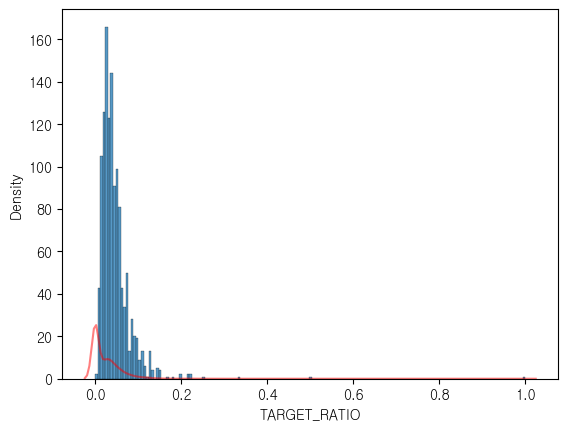

In [26]:
sns.kdeplot(ltc.TARGET_RATIO, color='red', alpha=0.5) #, clip=(0.0001, 1))
sns.histplot(ltc.TARGET_RATIO, binrange=(0.000000000001, 1)) 

In [27]:
# 1. LTC_ID별로 그룹화하고 TARGET_YN의 평균(또는 합계)을 계산
grouped_result = prs.groupby('LTC_ID')['TARGET_YN'].sum().reset_index()

ltc = ltc[['LTC_ID','LTC_NM','ADDRESS_SIDO_NM','PRS_CNT','GPS_X','GPS_Y','TARGET_RATIO']]
ltc = ltc.merge(grouped_result, on='LTC_ID', how='left')
ltc = ltc.rename(columns={'TARGET_YN': 'TARGET_COUNT'})
ltc

,LTC_ID,LTC_NM,ADDRESS_SIDO_NM,PRS_CNT,GPS_X,GPS_Y,TARGET_RATIO,TARGET_COUNT
0,2-11674-00001,미소짓는귀중함재가,경기도,66,127.224122,37.390034,0.000000,0
1,2-11674-00003,열정적인위안요양센터,서울특별시,178,127.011455,37.651450,0.016854,3
2,2-11674-00004,정성스러운센터,경기도,28,127.579508,37.097537,0.000000,0
3,2-11674-00005,충실한안식복지센터,인천광역시,49,126.481482,37.663736,0.081633,4
4,2-11674-00007,소중한응원요양센터,경기도,37,127.196075,37.974927,0.000000,0
...,...,...,...,...,...,...,...,...
2495,3-93751-00011,효도하는응원센터,대구광역시,77,128.524026,35.895532,0.090909,7
2496,3-93751-00012,행복한귀중함요양센터,대구광역시,92,128.557807,35.824285,0.032609,3
2497,3-93751-00013,열정적인친절케어,대구광역시,95,128.584360,35.802019,0.031579,3
2498,3-93751-00015,사려깊은도움케어,대구광역시,97,128.560371,35.922970,0.000000,0


In [28]:
ltc['ADDRESS_SIDO_OLD_NM'] = ltc['ADDRESS_SIDO_NM']
ltc['ADDRESS_SIDO_OLD_NM'] = ltc['ADDRESS_SIDO_OLD_NM'].replace('강원특별자치도','강원도')
ltc['ADDRESS_SIDO_OLD_NM'] = ltc['ADDRESS_SIDO_OLD_NM'].replace('전북특별자치도','전라북도')

In [29]:
r_list = ltc['ADDRESS_SIDO_OLD_NM'].unique()

for r in r_list:
    print(r)

경기도
서울특별시
인천광역시
충청남도
충청북도
대구광역시
경상북도
울산광역시
전라북도
전라남도
광주광역시
경상남도
부산광역시
제주특별자치도
세종특별자치시
대전광역시
강원도


In [30]:
ltc['ADDRESS_SIDO_NM'].unique()

array(['경기도', '서울특별시', '인천광역시', ..., '세종특별자치시', '대전광역시', '강원특별자치도'],
      dtype=object)

In [31]:
r_list = ltc['ADDRESS_SIDO_NM'].unique()

for r in r_list:
    print(r)

경기도
서울특별시
인천광역시
충청남도
충청북도
대구광역시
경상북도
울산광역시
전북특별자치도
전라남도
광주광역시
경상남도
부산광역시
제주특별자치도
세종특별자치시
대전광역시
강원특별자치도


In [32]:
ltc.columns

Index(['LTC_ID', 'LTC_NM', 'ADDRESS_SIDO_NM', 'PRS_CNT', 'GPS_X', 'GPS_Y',
       'TARGET_RATIO', 'TARGET_COUNT', 'ADDRESS_SIDO_OLD_NM'],
      dtype='object')

In [33]:
ltc = ltc[['LTC_ID', 'LTC_NM', 'ADDRESS_SIDO_NM', 'ADDRESS_SIDO_OLD_NM', 'PRS_CNT', 'GPS_X', 'GPS_Y', 'TARGET_RATIO', 'TARGET_COUNT']]
ltc

,LTC_ID,LTC_NM,ADDRESS_SIDO_NM,ADDRESS_SIDO_OLD_NM,PRS_CNT,GPS_X,GPS_Y,TARGET_RATIO,TARGET_COUNT
0,2-11674-00001,미소짓는귀중함재가,경기도,경기도,66,127.224122,37.390034,0.000000,0
1,2-11674-00003,열정적인위안요양센터,서울특별시,서울특별시,178,127.011455,37.651450,0.016854,3
2,2-11674-00004,정성스러운센터,경기도,경기도,28,127.579508,37.097537,0.000000,0
3,2-11674-00005,충실한안식복지센터,인천광역시,인천광역시,49,126.481482,37.663736,0.081633,4
4,2-11674-00007,소중한응원요양센터,경기도,경기도,37,127.196075,37.974927,0.000000,0
...,...,...,...,...,...,...,...,...,...
2495,3-93751-00011,효도하는응원센터,대구광역시,대구광역시,77,128.524026,35.895532,0.090909,7
2496,3-93751-00012,행복한귀중함요양센터,대구광역시,대구광역시,92,128.557807,35.824285,0.032609,3
2497,3-93751-00013,열정적인친절케어,대구광역시,대구광역시,95,128.584360,35.802019,0.031579,3
2498,3-93751-00015,사려깊은도움케어,대구광역시,대구광역시,97,128.560371,35.922970,0.000000,0


In [35]:
ltc['TARGET_YN'] = np.where(ltc['TARGET_COUNT'] >= 1, 1, 0)

C:\Users\pooko\AppData\Local\Temp\ipykernel_7144\3232245703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ltc['TARGET_YN'] = np.where(ltc['TARGET_COUNT'] >= 1, 1, 0)


In [37]:
ltc.describe()

,PRS_CNT,GPS_X,GPS_Y,TARGET_RATIO,TARGET_COUNT,TARGET_YN
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,40.000000,127.614904,36.332664,0.023259,0.949600,0.501600
std,36.727194,0.929245,1.144368,0.038360,1.345431,0.500097
min,1.000000,124.603147,33.168355,0.000000,0.000000,0.000000
25%,17.000000,126.895109,35.404691,0.000000,0.000000,0.000000
50%,27.000000,127.407768,36.416711,0.006252,1.000000,1.000000
75%,48.000000,128.403299,37.375366,0.038462,1.000000,1.000000
max,251.000000,131.111102,38.526557,1.000000,11.000000,1.000000


In [38]:
ltc.to_csv('ltc_result.csv', index=False)

In [39]:
ltc['TARGET_YN'].sum()

1254

In [41]:
ltc.describe()

,PRS_CNT,GPS_X,GPS_Y,TARGET_RATIO,TARGET_COUNT,TARGET_YN
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,40.000000,127.614904,36.332664,0.023259,0.949600,0.501600
std,36.727194,0.929245,1.144368,0.038360,1.345431,0.500097
min,1.000000,124.603147,33.168355,0.000000,0.000000,0.000000
25%,17.000000,126.895109,35.404691,0.000000,0.000000,0.000000
50%,27.000000,127.407768,36.416711,0.006252,1.000000,1.000000
75%,48.000000,128.403299,37.375366,0.038462,1.000000,1.000000
max,251.000000,131.111102,38.526557,1.000000,11.000000,1.000000


In [ ]:
ltc.groupby('ADDRESS_SIDO_NM').agg